In [1]:
from numpy import add
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm
from scipy.stats import describe
from matplotlib.pyplot import hist

from selenium.webdriver import Firefox
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By

from pandas import read_csv, DataFrame, Series, options

options.display.max_rows = 300

from re import sub
from ast import literal_eval
from numpy import int64, average, std

options = Options()
options.headless = False
options.page_load_strategy = "normal"

In [ ]:
# my_collection = ["Neroli Portofino", "Mugler Cologne", "Encre Noire",
#                 "Armani Code", "Aventus", "Terre d'Hermes", "La Nuit de l'Homme",
#                 "Tobacco Vanille", "Le Male", "Azzaro pour Homme",
#                 "Dior Homme Intense 2011", "Fahrenheit", "Tuscan Leather",
#                 "Sauvage", "Acqua di Gio", "The One for Men",
#                 "Eau Sauvage", "Virgin Island Water", "Cool Water",
#                 "Dior Homme Cologne 2013", "Versace Man Eau Fraiche",
#                 "L'Eau d'Issey Pour Homme", "Un Jardin Sur Le Nil"]
# fragdb_notes = read_csv('frags_notes.csv', index_col=0).loc[fragdb.index.intersection(my_collection)]
# fragdb_accords = read_csv('frags_accords.csv', index_col=0).loc[fragdb.index.intersection(my_collection)]

In [3]:
with Firefox(options=options) as driver:
    driver.implicitly_wait(10)
    driver.get("https://www.fragrantica.com/notes/")

    note_group_names = []
    for i in ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]:
        note_group_names.append(
            driver.find_element(
                By.CSS_SELECTOR,
                f"#groupnotes_group_{i}_title > div:nth-child(1) > h2:nth-child(1)",
            ).text.title()
        )

    note_group_notes = []
    i = 0
    for j in [6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39]:
        note_group_notes.append(
            sub(
                r"\n\n",
                ",",
                driver.find_element(
                    By.CSS_SELECTOR,
                    f".grid-padding-x > div:nth-child({j}) > div:nth-child(1)",
                ).text,
            ).split(",")
        )
        i = i + 1

note_groups = list(zip(note_group_names, note_group_notes))

In [4]:
fragdb_accords = read_csv("frags_accords.csv", index_col=0)
fragdb_notes = read_csv("frags_notes.csv", index_col=0)

fragdb_groups = DataFrame(index=fragdb_notes.index)
for note_group in note_groups:
    fragdb_groups.insert(
        len(fragdb_groups.columns),
        f"Group_{note_group[0]}",
        fragdb_notes[fragdb_notes.columns.intersection(note_group[1])].sum(axis=1),
    )
fragdb_groups.to_csv("frags_groups.csv")

fragdb_seasons = read_csv("frags_seasons.csv", index_col=0)

In [5]:
fragdb_notes = fragdb_notes.div(fragdb_notes.max(axis=1), axis=0).dropna()

Most closely related fragrances:

In [6]:
accords_cosine_array = cosine_similarity(fragdb_accords).round(3)
notes_cosine_array = cosine_similarity(fragdb_notes).round(3)
groups_cosine_array = cosine_similarity(fragdb_groups).round(3)
seasons_cosine_array = cosine_similarity(fragdb_seasons).round(3)
closest_frags = {}

for i in range(0, len(notes_cosine_array)):
    for j in range(0, i):
        if (
            notes_cosine_array[i][j] > 0.7
            and fragdb_notes.index[i] not in fragdb_notes.index[j]
            and fragdb_notes.index[j] not in fragdb_notes.index[i]
        ):
            closest_frags[f"{fragdb_notes.index[i]} / {fragdb_notes.index[j]}"] = (
                notes_cosine_array[i][j],
                accords_cosine_array[i][j],
                groups_cosine_array[i][j],
                seasons_cosine_array[i][j],
            )

weights = [0.0, 1.0, 0.0, 0.0]
for pair in sorted(
    closest_frags.items(),
    key=lambda x: average([x[1][0], x[1][1], x[1][2], x[1][3]], weights=weights),
    reverse=True,
):
    print(f"{pair[1]} : {pair[0]}")

(0.703, 0.942, 0.96, 0.986) : Eau Sauvage / Chrome
(0.704, 0.834, 0.906, 0.996) : Chrome / Versace Pour Homme
(0.71, 0.678, 0.855, 0.996) : Club de Nuit Intense Man / Aventus
(0.716, 0.676, 0.405, 0.739) : Les Exclusifs de Chanel Sycomore / Encre Noire
(0.776, 0.645, 0.331, 0.8) : L’Ambre des Merveilles / Gaultier 2
(0.705, 0.346, 0.0, 0.586) : Valentino Uomo Intense / Dior Homme Intense 2007
(0.711, 0.219, 0.434, 0.662) : CK One Shock For Him / The One for Men Eau de Parfum
(0.775, 0.0, 0.142, 0.349) : 4711 Original Eau de Cologne / Eau Sauvage


(array([3., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 2.]),
 array([0.703  , 0.70665, 0.7103 , 0.71395, 0.7176 , 0.72125, 0.7249 ,
        0.72855, 0.7322 , 0.73585, 0.7395 , 0.74315, 0.7468 , 0.75045,
        0.7541 , 0.75775, 0.7614 , 0.76505, 0.7687 , 0.77235, 0.776  ]),
 <a list of 20 Patch objects>)

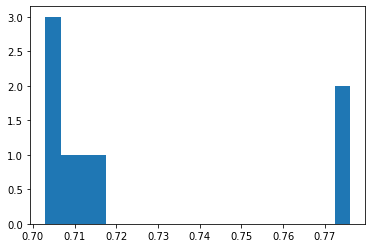

In [7]:
hist([cosine[0] for cosine in closest_frags.values()], bins=20)

In [ ]:
hist([cosine[1] for cosine in closest_frags.values()], bins=20)

In [ ]:
hist([cosine[2] for cosine in closest_frags.values()], bins=20)

In [15]:
season = "Winter"
print(fragdb_seasons.sort_values(season, ascending=False)[season].iloc[:10])

A*Men                      0.549296
Tobacco Vanille            0.520000
Spicebomb Extreme          0.519685
Interlude Man              0.513043
Joop! Homme                0.500000
Chocolate Greedy           0.496296
By the Fireplace           0.495652
Dior Homme Intense 2007    0.494845
M7                         0.490196
Dior Homme Parfum          0.482456
Name: Winter, dtype: float64


In [31]:
fragdb_seasons.std(axis=1).sort_values()

Bleu de Chanel Eau de Parfum                             0.040116
Datura Noir                                              0.040713
Terre d'Hermes Parfum                                    0.052887
Molecule 01                                              0.054867
Eros                                                     0.056954
Acqua di Parma Blu Mediterraneo - Mandorlo di Sicilia    0.060988
Legend                                                   0.063181
Dolce&Gabbana pour Homme (1994)                          0.065705
Prada Amber Pour Homme (Prada Man)                       0.065863
Bleu de Chanel                                           0.069555
Fierce                                                   0.071325
Allure Homme Sport Eau Extreme                           0.072156
Sauvage                                                  0.074825
L'Eau Bleue d'Issey Pour Homme                           0.074992
Declaration                                              0.075959
Reflection

Top 10 Fragrances by highest presence of a given note:

In [18]:
note = "Lavender"
print(fragdb_notes.sort_values(note, ascending=False)[note].iloc[:10])

Azzaro pour Homme                  1.0
Egoiste Platinum                   1.0
F by Ferragamo Black               1.0
Legend                             1.0
Drakkar Noir                       1.0
Eternity For Men                   1.0
Dolce&Gabbana pour Homme (1994)    1.0
CK be                              1.0
Blue Jeans                         1.0
Dreamer The Original Edition       1.0
Name: Lavender, dtype: float64
